In [2]:
import numpy as np
import os
import h5py
import tomocam
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

In [3]:
tomocam.cTomocam.set_num_of_gpus(1)

In [4]:
class CTViewer:
    def __init__(self, vol):
        self.volume = vol
        self.index = 0
        self.fig, self.ax = plt.subplots()
        self.ax.imshow(self.volume[self.index])
        self.fig.canvas.mpl_connect('key_press_event', self.update)
        
    def set_clim(self, lims):
        self.ax.images[0].set_clim(lims)
        self.fig.canvas.draw()
        
    def update(self, event):
        if event.key == 'right':
            self.next_slice()
        elif event.key == 'left':
            self.prev_slice()
        elif event.key == 'up':
            self.jump_fwd()
        elif event.key == 'down':
            self.jump_back()
        self.fig.canvas.draw()
        
    def next_slice(self):
        self.index = (self.index + 1) % self.volume.shape[0]  # wrap around using %
        self.ax.images[0].set_array(self.volume[self.index])
        
    def prev_slice(self):
        self.index = (self.index - 1) % self.volume.shape[0]  # wrap around using %
        self.ax.images[0].set_array(self.volume[self.index])
            
    def jump_fwd(self):
        self.index = (self.index + 5) % self.volume.shape[0]  # wrap around using %
        self.ax.images[0].set_array(self.volume[self.index])
             
    def jump_back(self):
        self.index = (self.index - 5) % self.volume.shape[0]  # wrap around using %
        self.ax.images[0].set_array(self.volume[self.index])

In [5]:
sdir = '/data/tomochallange/phantom_00016/'
filename = 'phantom_00016.h5'

In [6]:
fp = h5py.File(os.path.join(sdir, filename), 'r')
data = fp['/projs']

# put data into sinogram format
s = np.array(data[:,:20,:].transpose(1,0,2))

# make sure to deep-copy
angs = np.array(fp['/angs'], copy=True)

In [7]:
# plot for sanity check
#img = CTViewer(s)

In [8]:
# create tomocam.DistArrays
nslc, nproj, nrow = s.shape
sino = tomocam.DistArray(s.copy())
model = tomocam.DistArray(np.ones((nslc, nrow, nrow), dtype=np.float32))

c = 0.9
lam = 0.5
prev_err = np.Infinity

for itr in range(50):
    gradients = model.copy()
    tomocam.calc_gradients(gradients, sino, angs, center=640, over_sample=1.5)
    tomocam.update_total_variation(model, gradients)
    
    error = lam * gradients.norm()
    if error > prev_err:
        lam *= c
    else:
        prev_err = error
        # update
        tomocam.axpy(-lam, gradients, model)
        print(error)

44720.265625
29568.423828125
19860.1171875
13787.0732421875
10137.9013671875
8068.39794921875
6975.11962890625
6453.5146484375
6269.03857421875
5679.5466796875
5270.374160156251
4960.295758300782
4705.005226464845
4478.630799990236
4265.589648607912
4058.0058876899425
3851.327911906056
3643.6942391288567
3435.665553833544
3228.2744098136354
3023.1318263146986
2821.6244750195965
2625.1219874847106
2435.2012916509457
2252.7021668669586
2078.589693633298
1913.4522893021303
1757.6671764867542
1611.4095111966856


<IPython.core.display.Javascript object>


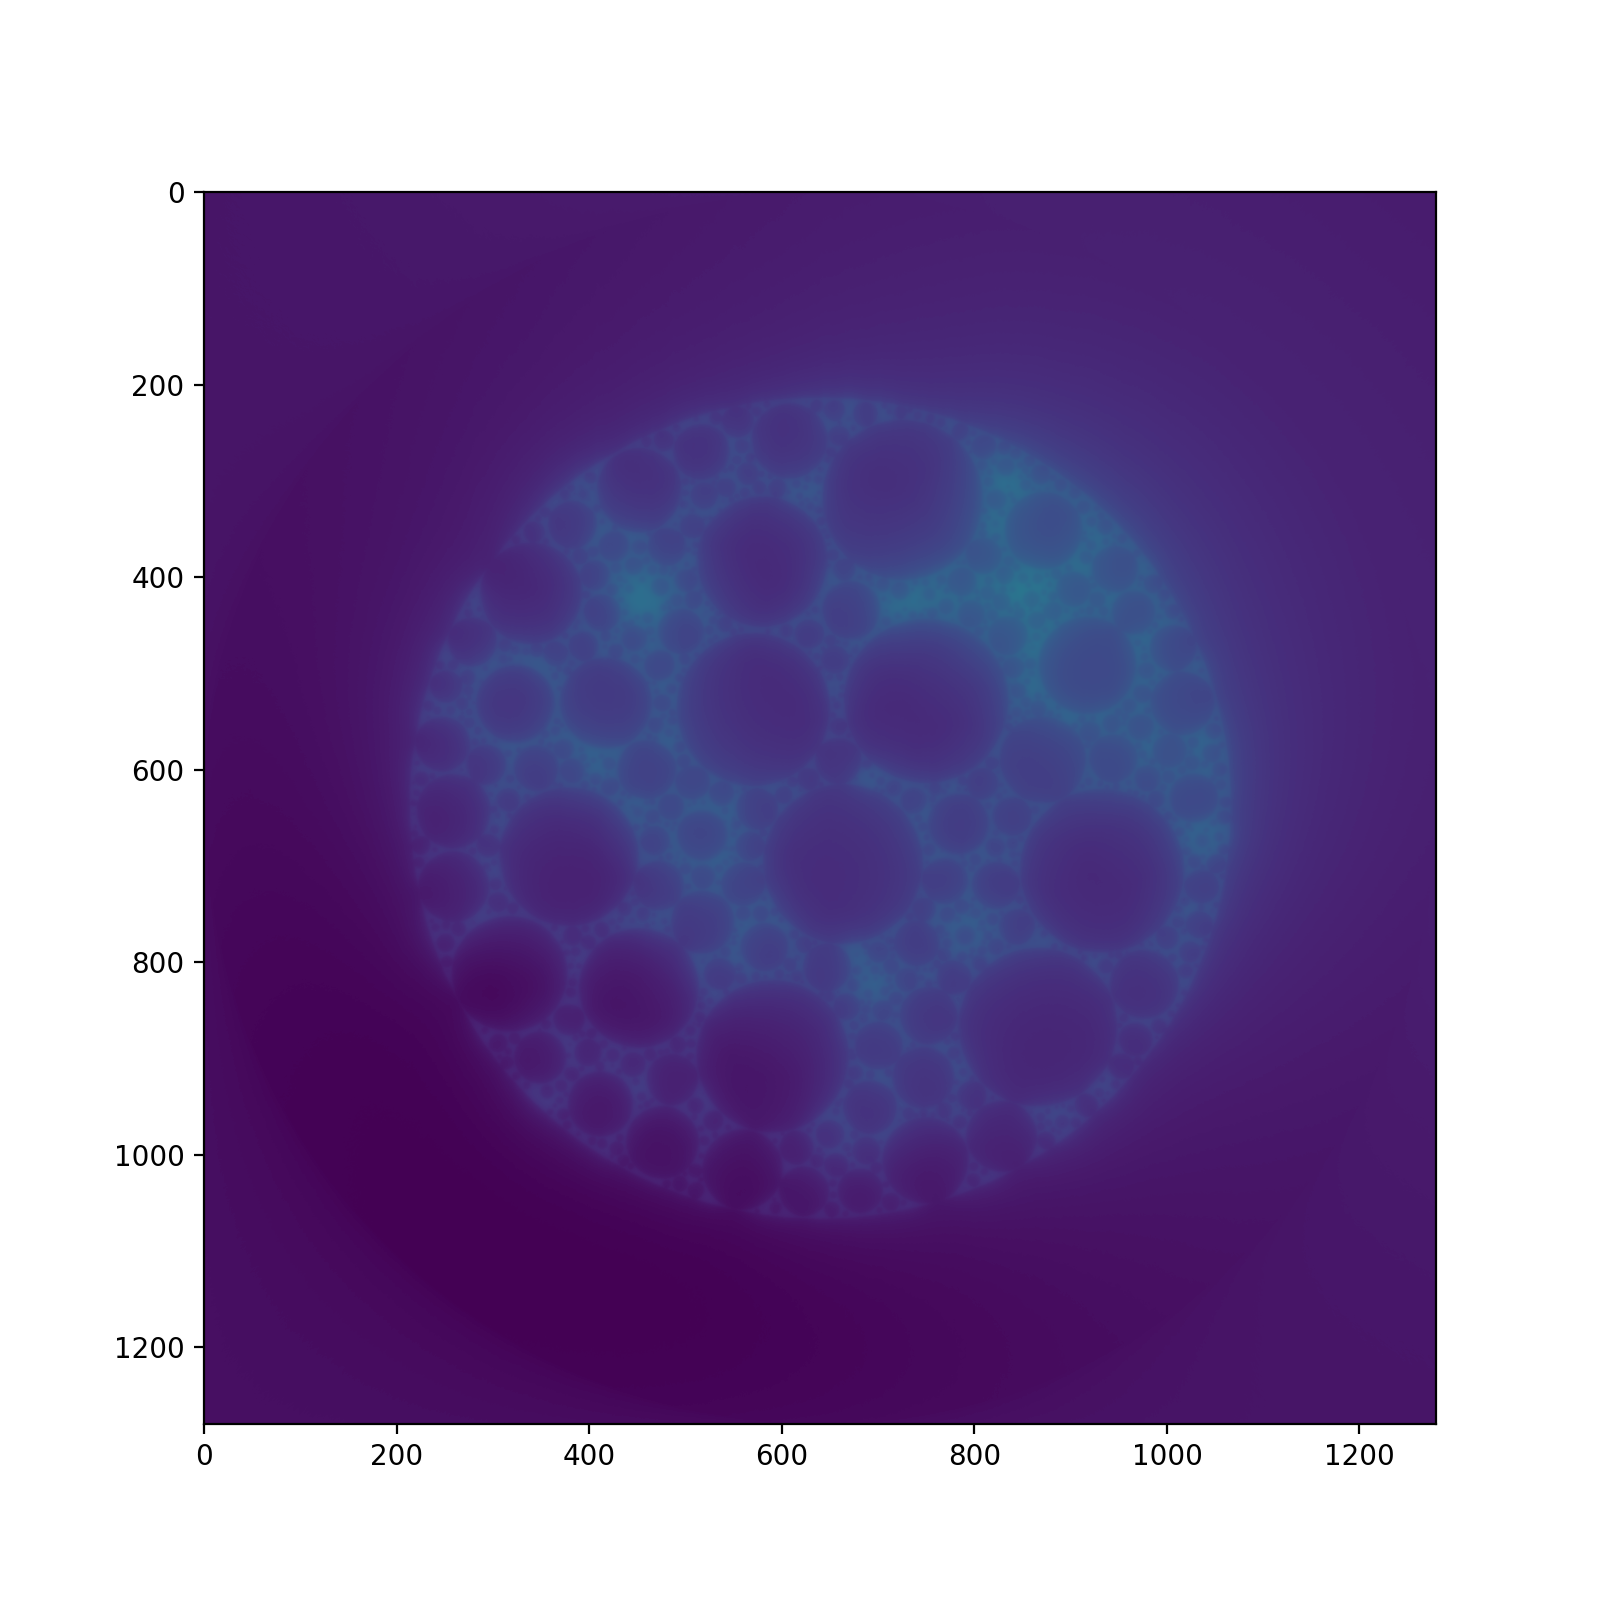

In [41]:
recon = model.to_numpy()
img2 = CTViewer(recon)
#img2.set_clim([10, None])